# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [21]:
# Dependencies and Setup
import sys
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
#import time
from scipy.stats import linregress

# Import API key
sys.path.insert(0,r'c:\Users\Owen\Desktop\DSV\_HW_Repos\python-api-challenge\common')
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "../output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []
haveEnoughCities = False

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = list(zip(lats, lngs))

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
  
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

634

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
cityObjs = []
i = -1
for city in cities:
    i += 1
    try:
        print(f'processing: {i}. {city}')
        owdResult = requests.get(f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={weather_api_key}&units=imperial')
    except:
        print('Request aborted. Request Denied')
    
    if owdResult.status_code == 200:
        print('complete')
        cityObjs.append(owdResult.json())
    else:
        print(f'Request aborted. Status Code: {owdResult.status_code}')



e
processing: 105. jiuquan
complete
processing: 106. sao joao da barra
complete
processing: 107. kologriv
complete
processing: 108. alice springs
complete
processing: 109. aswan
complete
processing: 110. the valley
complete
processing: 111. yomitan
Request aborted. Status Code: 404
processing: 112. haines junction
complete
processing: 113. talara
complete
processing: 114. mount gambier
complete
processing: 115. attawapiskat
Request aborted. Status Code: 404
processing: 116. akranes
complete
processing: 117. kavieng
complete
processing: 118. cabo san lucas
complete
processing: 119. kisesa
complete
processing: 120. chickasha
complete
processing: 121. nikolskoye
complete
processing: 122. lagunillas
complete
processing: 123. avarua
complete
processing: 124. guerrero negro
complete
processing: 125. liniere
Request aborted. Status Code: 404
processing: 126. cam ranh
complete
processing: 127. asau
complete
processing: 128. saint-pierre
complete
processing: 129. dwarka
complete
processing: 130

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [13]:
#Write city weather data to csv
with open(output_data_file, 'w', newline = '', encoding = 'utf-8') as outFile:
    columnNames = ['City Name', 'City ID', 'Latitude', 'Longitude', 'Max Temp(F)', 'Humidity(%)', 'Wind Speed (m/s)', 'Cloudiness(%)', 'Country Code', 'Date']
    writer = csv.DictWriter(outFile, fieldnames = columnNames)
    writer.writeheader()
    for cityObj in cityObjs:
        writer.writerow({
            'City Name': cityObj['name'], 
            'City ID': cityObj['id'], 
            'Latitude': cityObj['coord']['lat'], 
            'Longitude': cityObj['coord']['lon'], 
            'Max Temp(F)': cityObj['main']['temp_max'], 
            'Humidity(%)': cityObj['main']['humidity'],
            'Wind Speed (m/s)': cityObj['wind']['speed'], 
            'Cloudiness(%)': cityObj['clouds']['all'], 
            'Country Code': cityObj['sys']['country'], 
            'Date': cityObj['dt']
            })


#Write city weather data to DataFrame
cityDataDict = {}
for cityObj in cityObjs:
    cityID = cityObj['id']
    cityName = cityObj['name']
    cityCountryCode = cityObj['sys']['country']
    cityLat = cityObj['coord']['lat']
    cityLng = cityObj['coord']['lon']
    cityMaxTemp = cityObj['main']['temp_max']
    cityHum = cityObj['main']['humidity']
    cityCloud = cityObj['clouds']['all']
    cityWindSpeed = cityObj['wind']['speed']
    cityDate = cityObj['dt']
    cityDictEntry = {
                    'city_name': cityName,
                    'lat': cityLat, 
                    'lng': cityLng,
                    'max_temp': cityMaxTemp,
                    'hum': cityHum,
                    'cloud': cityCloud,
                    'wind_speed': cityWindSpeed,
                    'country_code': cityCountryCode,
                    'date': cityDate 
                    }
    cityDataDict[cityID] = cityDictEntry
city_data = pd.DataFrame(cityDataDict).transpose()
city_data.head()


,city_name,lat,lng,max_temp,hum,cloud,wind_speed,country_code,date
2126710,Beringovskiy,63.05,179.32,40.95,88,99,12.71,RU,1603215185
3372760,Praia da Vitória,38.73,-27.07,64.4,72,40,27.34,PT,1603215352
2019951,Mirny,62.54,113.96,19.4,85,90,6.71,RU,1603215352
3419842,Sisimiut,66.94,-53.67,35.71,94,100,13.53,GL,1603215353
4032243,Vaini,-21.2,-175.2,69.8,77,40,9.17,TO,1603215353


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [14]:
#retain only rows where humidity is less than or equal to 100
city_data = city_data[city_data['hum'] <= 100]


In [15]:
#  Get the indices of cities that have humidity over 100%.
humIndices = city_data[city_data['hum'] > 100].index
humIndices

Int64Index([], dtype='int64')

In [16]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = city_data[~city_data['hum'].isin(humIndices)]
clean_city_data

,city_name,lat,lng,max_temp,hum,cloud,wind_speed,country_code,date
2126710,Beringovskiy,63.05,179.32,40.95,88,99,12.71,RU,1603215185
3372760,Praia da Vitória,38.73,-27.07,64.4,72,40,27.34,PT,1603215352
2019951,Mirny,62.54,113.96,19.4,85,90,6.71,RU,1603215352
3419842,Sisimiut,66.94,-53.67,35.71,94,100,13.53,GL,1603215353
4032243,Vaini,-21.2,-175.2,69.8,77,40,9.17,TO,1603215353
...,...,...,...,...,...,...,...,...,...
1244926,Hambantota,6.12,81.12,79.7,82,0,17.27,LK,1603215494
2755249,Province of Groningen,53.25,6.75,55.4,87,20,11.41,NL,1603215494
2019135,Nizhniy Kuranakh,58.84,125.49,24.57,97,100,2.37,RU,1603215495
3653967,Muisne,0.6,-80.03,84.2,74,40,6.93,EC,1603215495


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

Text(0, 0.5, 'Max Temp (F)')

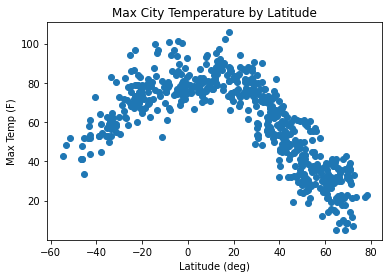

In [17]:
plt.scatter(clean_city_data['lat'].values, clean_city_data['max_temp'].values)
plt.title('Max City Temperature by Latitude')
plt.xlabel('Latitude (deg)')
plt.ylabel('Max Temp (F)')

## Latitude vs. Humidity Plot

Text(0, 0.5, 'Humidity (%)')

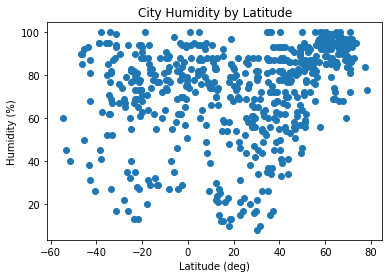

In [18]:
plt.scatter(clean_city_data['lat'].values, clean_city_data['hum'].values)
plt.title('City Humidity by Latitude')
plt.xlabel('Latitude (deg)')
plt.ylabel('Humidity (%)')

## Latitude vs. Cloudiness Plot

Text(0, 0.5, 'Cloudiness (%)')

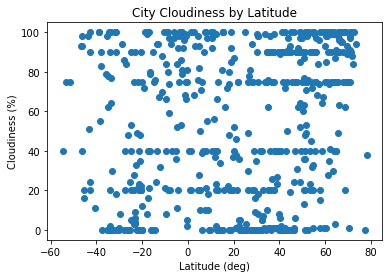

In [19]:
plt.scatter(clean_city_data['lat'].values, clean_city_data['cloud'].values)
plt.title('City Cloudiness by Latitude')
plt.xlabel('Latitude (deg)')
plt.ylabel('Cloudiness (%)')

## Latitude vs. Wind Speed Plot

Text(0, 0.5, 'Wind Speed(mph)')

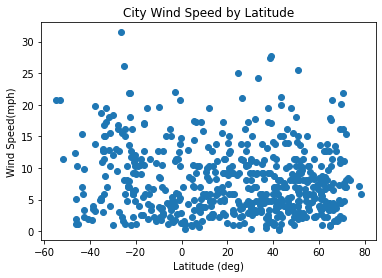

In [20]:
plt.scatter(clean_city_data['lat'].values, clean_city_data['wind_speed'].values)
plt.title('City Wind Speed by Latitude')
plt.xlabel('Latitude (deg)')
plt.ylabel('Wind Speed(mph)')

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: -0.88


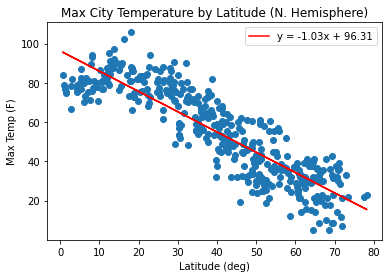

In [79]:
clean_city_data_n = clean_city_data[clean_city_data['lat'] > 0]

plt.scatter(clean_city_data_n['lat'].values, clean_city_data_n['max_temp'].values)
plt.title('Max City Temperature by Latitude (N. Hemisphere)')
plt.xlabel('Latitude (deg)')
plt.ylabel('Max Temp (F)')

x = clean_city_data_n['lat'].values.tolist()
y = clean_city_data_n['max_temp'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.73


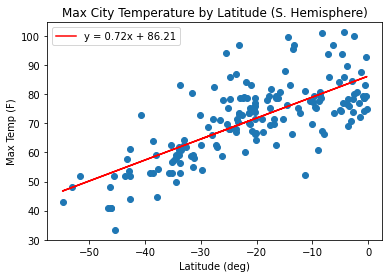

In [80]:
clean_city_data_s = clean_city_data[clean_city_data['lat'] < 0]

plt.scatter(clean_city_data_s['lat'].values, clean_city_data_s['max_temp'].values)
plt.title('Max City Temperature by Latitude (S. Hemisphere)')
plt.xlabel('Latitude (deg)')
plt.ylabel('Max Temp (F)')

x = clean_city_data_s['lat'].values.tolist()
y = clean_city_data_s['max_temp'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.39


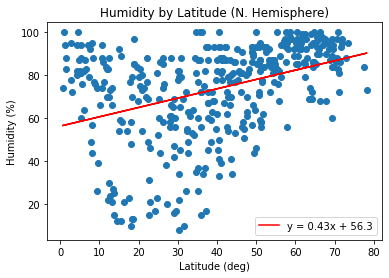

In [81]:
clean_city_data_n = clean_city_data[clean_city_data['lat'] > 0]

plt.scatter(clean_city_data_n['lat'].values, clean_city_data_n['hum'].values)
plt.title('Humidity by Latitude (N. Hemisphere)')
plt.xlabel('Latitude (deg)')
plt.ylabel('Humidity (%)')

x = clean_city_data_n['lat'].values.tolist()
y = clean_city_data_n['hum'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.03


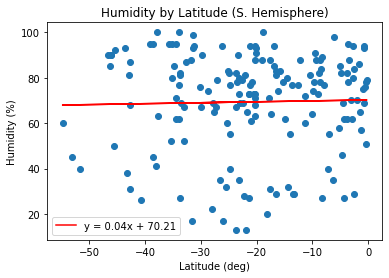

In [82]:
clean_city_data_s = clean_city_data[clean_city_data['lat'] < 0]

plt.scatter(clean_city_data_s['lat'].values, clean_city_data_s['hum'].values)
plt.title('Humidity by Latitude (S. Hemisphere)')
plt.xlabel('Latitude (deg)')
plt.ylabel('Humidity (%)')

x = clean_city_data_s['lat'].values.tolist()
y = clean_city_data_s['hum'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.32


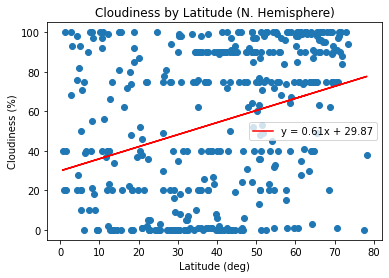

In [83]:
clean_city_data_n = clean_city_data[clean_city_data['lat'] > 0]

plt.scatter(clean_city_data_n['lat'].values, clean_city_data_n['cloud'].values)
plt.title('Cloudiness by Latitude (N. Hemisphere)')
plt.xlabel('Latitude (deg)')
plt.ylabel('Cloudiness (%)')

x = clean_city_data_n['lat'].values.tolist()
y = clean_city_data_n['cloud'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.17


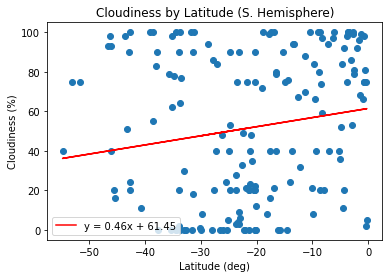

In [84]:
clean_city_data_s = clean_city_data[clean_city_data['lat'] < 0]

plt.scatter(clean_city_data_s['lat'].values, clean_city_data_s['cloud'].values)
plt.title('Cloudiness by Latitude (S. Hemisphere)')
plt.xlabel('Latitude (deg)')
plt.ylabel('Cloudiness (%)')

x = clean_city_data_s['lat'].values.tolist()
y = clean_city_data_s['cloud'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.02


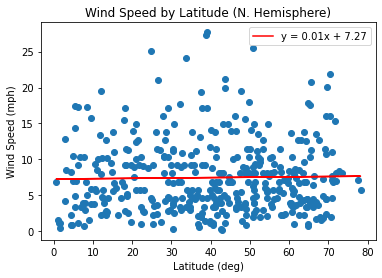

In [85]:
clean_city_data_n = clean_city_data[clean_city_data['lat'] > 0]

plt.scatter(clean_city_data_n['lat'].values, clean_city_data_n['wind_speed'].values)
plt.title('Wind Speed by Latitude (N. Hemisphere)')
plt.xlabel('Latitude (deg)')
plt.ylabel('Wind Speed (mph)')

x = clean_city_data_n['lat'].values.tolist()
y = clean_city_data_n['wind_speed'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: -0.16


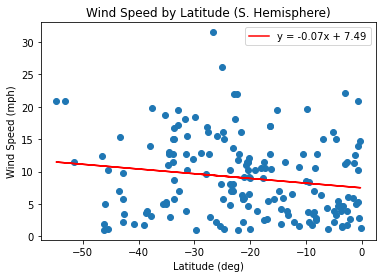

In [86]:
clean_city_data_s = clean_city_data[clean_city_data['lat'] < 0]

plt.scatter(clean_city_data_s['lat'].values, clean_city_data_s['wind_speed'].values)
plt.title('Wind Speed by Latitude (S. Hemisphere)')
plt.xlabel('Latitude (deg)')
plt.ylabel('Wind Speed (mph)')

x = clean_city_data_s['lat'].values.tolist()
y = clean_city_data_s['wind_speed'].values.tolist()
m, b, r, p, e = linregress(x, y)
print(f'The r-value is: {round(r,2)}')

yLine = [round(m*i+b,2) for i in x]
plt.plot(x, yLine, 'r', label = f'y = {round(m,2)}x + {round(b,2)}')
plt.legend()